# This Notebook contains the code for the simulation of the Poisson process

## Definition of a Poisson Process

A **Poisson process** is a stochastic process that models the occurrence of events in continuous time. It is characterized by the following mathematical properties:

### Mathematical Definition

Let $(N_t)_{t \in \mathbb{R}^+}$ denote the Poisson process and $\mathbb{P}$ the probability measure. The process satisfies:

1. **Independent increments**: 
   $$\forall t_0 = 0 \leq t_1 < \cdots < t_k,$$
   the random variables $(N_{t_k} - N_{t_{k-1}}), \ldots, (N_{t_1} - N_{t_0})$ are independent.

2. **Infinitesimal probability of one event**:
   $$\mathbb{P}(N_{t+h} - N_t = 1) = \lambda h + o(h)$$
   as $h \to 0^+$ (for fixed $t$), where $\lambda > 0$ is the **intensity parameter**.

3. **Infinitesimal probability of multiple events**:
   $$\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$$
   as $h \to 0^+$ (for fixed $t$).

From the last two properties, we can deduce:
$$\mathbb{P}(N_{t+h} - N_t = 0) = 1 - \lambda h + o(h)$$

### Key Properties

- **Starting condition**: $N_0 = 0$
- **Stationary increments**: The distribution of $N_{t+s} - N_t$ depends only on $s$, not on $t$
- **Distribution**: For any $t > 0$, $N_t \sim \text{Poisson}(\lambda t)$
- **Mean**: $\mathbb{E}[N_t] = \lambda t$
- **Variance**: $\text{Var}(N_t) = \lambda t$

### Inter-arrival Times

The times between consecutive events follow an **exponential distribution** with parameter $\lambda$:
$$T_i = S_i - S_{i-1} \sim \text{Exp}(\lambda)$$
where $S_i$ is the time of the $i$-th event.



## 1- Progressive Simulation

The **progressive simulation** method generates a Poisson process by simulating the sequence of event times directly. This approach is based on the fundamental property that inter-arrival times follow an exponential distribution.

### Algorithm

**Input**: Intensity parameter $\lambda > 0$, simulation horizon $T > 0$

**Output**: Sequence of event times $(T_i)_{i \geq 1}$ and process values $(N_t)_{t \in [0,T]}$

**Steps**:
1. Set $T_0 := 0$
2. For $i \geq 0$, repeat:
   - Simulate a random variable $\tau_{i+1} \sim \mathcal{E}(\lambda)$ independent of the past
   - Set $T_{i+1} := T_i + \tau_{i+1}$
   - Define $N_t = i$ for $t \in [T_i, T_{i+1}[$
3. Stop when $T_{i+1} > T$



Simulation Results:
Total number of events: 23
Theoretical mean: 20.00
Observed rate: 2.30
First 10 event times: [0.23463404498842955, 1.7396947604471902, 2.398067607219915, 2.8545388841078916, 2.939351319339065, 3.024149465296367, 3.0540688496007076, 4.059684281840678, 4.51922535865431, 5.134850389506606]


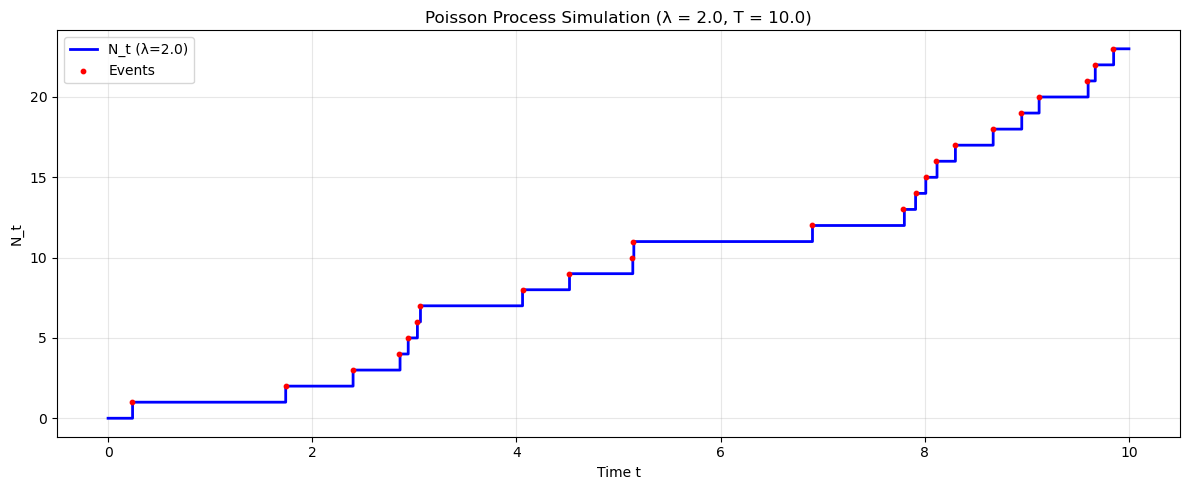

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
import random

def simulate_poisson_progressive(lmbda, T, seed=None):
    """
    Simulate a Poisson process using the progressive method.
    
    Parameters:
    - lmbda: intensity parameter (λ > 0)
    - T: simulation horizon (T > 0)
    - seed: random seed for reproducibility
    
    Returns:
    - event_times: list of event occurrence times
    - times: array of time points for plotting
    - counts: array of process values N_t
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize
    event_times = [0.0]  # T_0 = 0
    current_time = 0.0
    
    # Generate event times
    while True:
        # Simulate τ_{i+1} ~ Exp(λ)
        tau = np.random.exponential(1/lmbda)
        
        # Set T_{i+1} = T_i + τ_{i+1}
        next_time = current_time + tau
        
        # Stop if T_{i+1} > T
        if next_time > T:
            break
            
        event_times.append(next_time)
        current_time = next_time
    
    # Create time grid for plotting
    dt = 0.01
    times = np.arange(0, T + dt, dt)
    counts = np.zeros_like(times)
    
    # Define N_t = i for t ∈ [T_i, T_{i+1}[
    event_idx = 0
    for i, t in enumerate(times):
        # Find which interval t belongs to
        while event_idx < len(event_times) - 1 and t >= event_times[event_idx + 1]:
            event_idx += 1
        counts[i] = event_idx
    
    return event_times[1:], times, counts  # Remove T_0 = 0 from event_times

def plot_poisson_process(event_times, times, counts, lmbda, T):
    """
    Plot the Poisson process trajectory with event markers.
    """
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))
    
    # Plot 1: Process trajectory
    ax1.step(times, counts, where='post', linewidth=2, color='blue', label=f'N_t (λ={lmbda})')
    ax1.scatter(event_times, range(1, len(event_times) + 1), 
                color='red', s=10, zorder=5, label='Events')
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('N_t')
    ax1.set_title(f'Poisson Process Simulation (λ = {lmbda}, T = {T})')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    plt.tight_layout()
    plt.show()

# Example: Simulate and plot
def main():
    # Parameters
    lmbda = 2.0  # intensity
    T = 10.0     # simulation horizon
    
    # Simulate
    event_times, times, counts = simulate_poisson_progressive(lmbda, T, seed=42)
    
    # Display statistics
    print(f"Simulation Results:")
    print(f"Total number of events: {len(event_times)}")
    print(f"Theoretical mean: {lmbda * T:.2f}")
    print(f"Observed rate: {len(event_times) / T:.2f}")
    print(f"First 10 event times: {event_times[:10]}")
    
    # Plot
    plot_poisson_process(event_times, times, counts, lmbda, T)

# Run the simulation
if __name__ == "__main__":
    main()

## 2- Backward Simulation

The **backward simulation** method is based on the fundamental property that, given the total number of events $N_T$ in the interval $[0,T]$, the event times are uniformly distributed over this interval.

### Theoretical Foundation

**Proposition**: Given $N_T = k$, the jump times $(T_1, T_2, \ldots, T_k)$ are distributed as the order statistics of $k$ independent uniform random variables on $[0,T]$.

Mathematically:
$$\text{Given } N_T = k, \quad (T_1, \ldots, T_k) \stackrel{d}{=} (U_{(1)}, \ldots, U_{(k)})$$
where $U_{(1)} \leq U_{(2)} \leq \cdots \leq U_{(k)}$ are the order statistics of $U_1, \ldots, U_k \sim \mathcal{U}([0,T])$.

### Algorithm

**Input**: Intensity parameter $\lambda > 0$, simulation horizon $T > 0$

**Output**: Sequence of event times $(T_i)_{i \geq 1}$ and process values $(N_t)_{t \in [0,T]}$

**Steps**:
1. Simulate $N_T \sim \mathcal{P}(\lambda T)$ and obtain a number $k$
2. Simulate $U_1, \ldots, U_k \stackrel{iid}{\sim} \mathcal{U}([0,T])$
3. Sort them to obtain $T_1 < T_2 < \cdots < T_k$

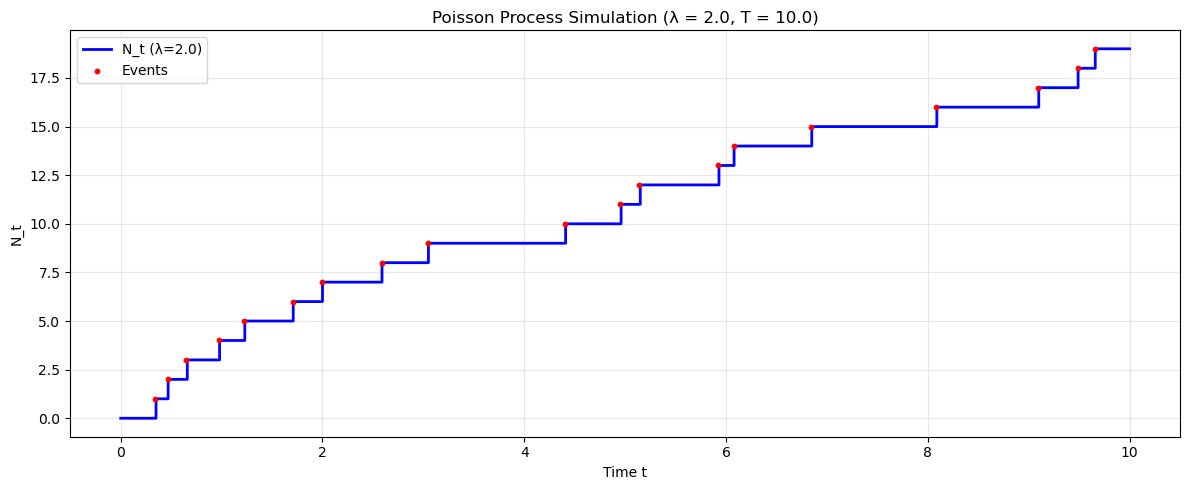

In [2]:
def simulate_poisson_backward(lmbda, T, seed=None):
    """
    Simulate a Poisson process using the backward method.
    
    Parameters:
    - lmbda: intensity parameter (λ > 0)
    - T: simulation horizon (T > 0)
    - seed: random seed for reproducibility
    
    Returns:
    - event_times: sorted list of event occurrence times
    - times: array of time points for plotting
    - counts: array of process values N_t
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Step 1: Simulate N_T ~ Poisson(λT)
    k = np.random.poisson(lmbda * T)
    
    if k == 0:
        # No events in [0,T]
        event_times = []
    else:
        # Step 2: Simulate k uniform random variables on [0,T]
        uniform_times = np.random.uniform(0, T, k)
        
        # Step 3: Sort them to get T_1 < T_2 < ... < T_k
        event_times = sorted(uniform_times)
    
    # Create time grid for plotting
    dt = 0.01
    times = np.arange(0, T + dt, dt)
    counts = np.zeros_like(times)
    
    # Define N_t = number of events before time t
    for i, t in enumerate(times):
        counts[i] = sum(1 for event_time in event_times if event_time <= t)
    
    return event_times, times, counts

# Example usage
def main():
    # Parameters
    lmbda = 2.0  # intensity
    T = 10.0      # simulation horizon
    
    # Compare methods
    event_times, times, counts = simulate_poisson_backward(lmbda, T)
    plot_poisson_process(event_times, times, counts, lmbda, T)
    

# Run comparison
if __name__ == "__main__":
    main()

## 3- Inhomogeneous Poisson Process

An **inhomogeneous (non-homogeneous) Poisson process** is a generalization where the intensity parameter $\lambda$ varies with time. Instead of a constant rate, we have a time-dependent intensity function $\lambda(t)$.

### Mathematical Definition

Let $(N_t)_{t \in \mathbb{R}^+}$ be an inhomogeneous Poisson process with intensity function $\lambda(t) \geq 0$. The process satisfies:

1. **Independent increments**: For any $0 \leq t_1 < t_2 < \cdots < t_n$, the increments $(N_{t_2} - N_{t_1}), (N_{t_3} - N_{t_2}), \ldots, (N_{t_n} - N_{t_{n-1}})$ are independent.

2. **Non-stationary increments**: The distribution of $N_{t+s} - N_t$ depends on both $s$ and $t$.

3. **Infinitesimal properties**:
   $$\mathbb{P}(N_{t+h} - N_t = 1) = \lambda(t) h + o(h)$$
   $$\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$$

### Key Properties

- **Mean function**: $\mathbb{E}[N_t] = \Lambda(t) = \int_0^t \lambda(s) ds$
- **Variance**: $\text{Var}(N_t) = \Lambda(t)$
- **Distribution**: $N_t \sim \text{Poisson}(\Lambda(t))$

where $\Lambda(t)$ is the **cumulative intensity function**.

### Simulation Methods

#### Method 1: Thinning Algorithm (Acceptance-Rejection)

**Steps**:
1. Find $\lambda^* = \sup_{t \in [0,T]} \lambda(t)$ (maximum intensity)
2. Simulate a homogeneous Poisson process with intensity $\lambda^*$
3. Accept each event at time $t$ with probability $\frac{\lambda(t)}{\lambda^*}$

#### Method 2: Inverse Transform Method

**Steps**:
1. Compute $\Lambda(t) = \int_0^t \lambda(s) ds$
2. Find the inverse function $\Lambda^{-1}$
3. Generate $U_i \sim \text{Uniform}(0,1)$
4. Set $T_i = \Lambda^{-1}(-\ln(U_i))$

In [5]:
def simulate_inhomogeneous_poisson_thinning(lambda_func, lambda_max, T, seed=None):
    """
    Simulate an inhomogeneous Poisson process using the thinning algorithm.
    
    Parameters:
    - lambda_func: function λ(t) - intensity function
    - lambda_max: maximum value of λ(t) over [0,T]
    - T: simulation horizon
    - seed: random seed for reproducibility
    
    Returns:
    - event_times: list of accepted event times
    - times: array of time points for plotting
    - counts: array of process values N_t
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Step 1: Generate homogeneous Poisson process with intensity λ*
    homogeneous_events = []
    current_time = 0.0
    
    while current_time < T:
        # Generate inter-arrival time ~ Exp(λ*)
        tau = np.random.exponential(1/lambda_max)
        current_time += tau
        if current_time <= T:
            homogeneous_events.append(current_time)
    
    # Step 2: Thinning - accept events with probability λ(t)/λ*
    accepted_events = []
    for t in homogeneous_events:
        acceptance_prob = lambda_func(t) / lambda_max
        if np.random.uniform() <= acceptance_prob:
            accepted_events.append(t)
    
    # Create time grid for plotting
    dt = 0.01
    times = np.arange(0, T + dt, dt)
    counts = np.zeros_like(times)
    
    # Build counting processw
    for i, t in enumerate(times):
        counts[i] = sum(1 for event_time in accepted_events if event_time <= t)
    
    return accepted_events, times, counts

def simulate_inhomogeneous_poisson_inverse(Lambda_inv_func, T, seed=None):
    """
    Simulate an inhomogeneous Poisson process using the inverse transform method.
    
    Parameters:
    - Lambda_func: cumulative intensity function Λ(t) = ∫λ(s)ds
    - Lambda_inv_func: inverse of Λ(t)
    - T: simulation horizon
    - seed: random seed for reproducibility
    
    Returns:
    - event_times: list of event times
    - times: array of time points for plotting
    - counts: array of process values N_t
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Generate exponential random variables
    event_times = []
    cumulative_intensity = 0.0
    
    while True:
        # Generate U ~ Uniform(0,1)
        U = np.random.uniform()
        
        # Increment cumulative intensity
        cumulative_intensity -= np.log(U)
        
        # Find corresponding time
        try:
            t = Lambda_inv_func(cumulative_intensity)
            if t <= T:
                event_times.append(t)
            else:
                break
        except:
            break
    
    # Create time grid for plotting
    dt = 0.01
    times = np.arange(0, T + dt, dt)
    counts = np.zeros_like(times)
    
    # Build counting process
    for i, t in enumerate(times):
        counts[i] = sum(1 for event_time in event_times if event_time <= t)
    
    return event_times, times, counts

def plot_inhomogeneous_process(event_times, times, counts, lambda_func, T, title=""):
    """
    Plot inhomogeneous Poisson process with intensity function.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Intensity function
    t_intensity = np.linspace(0, T, 1000)
    intensity_values = [lambda_func(t) for t in t_intensity]
    ax1.plot(t_intensity, intensity_values, 'r-', linewidth=2, label='λ(t)')
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('Intensity λ(t)')
    ax1.set_title(f'Intensity Function {title}')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Process trajectory
    ax2.step(times, counts, where='post', linewidth=2, color='blue', 
             label=f'N_t (N={len(event_times)})')
    ax2.scatter(event_times, range(1, len(event_times) + 1), 
                color='red', s=30, zorder=5, alpha=0.7, label='Events')
    ax2.set_xlabel('Time t')
    ax2.set_ylabel('N_t')
    ax2.set_title(f'Inhomogeneous Poisson Process {title}')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()



=== Inhomogeneous Poisson Process Examples ===


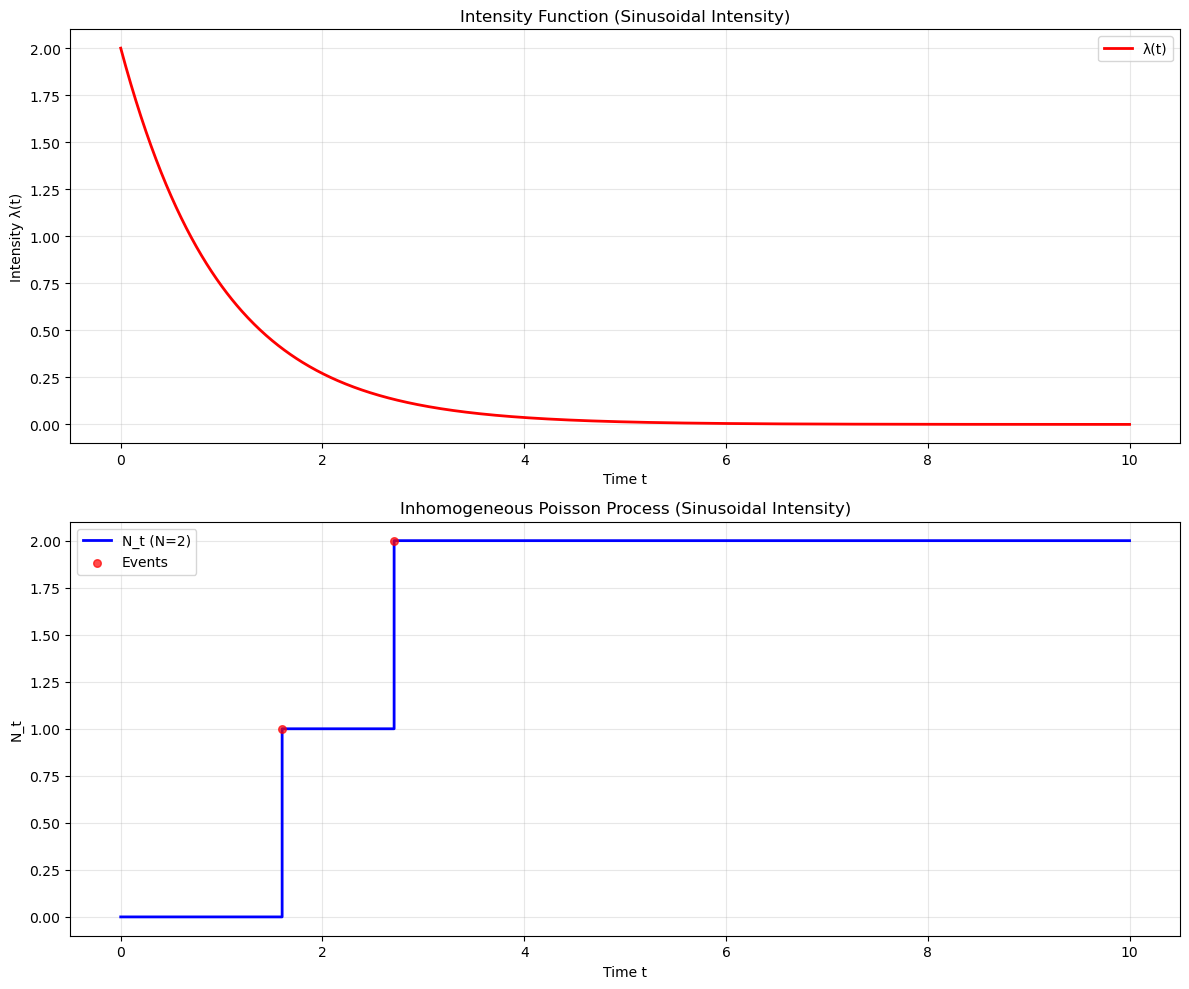

In [9]:
segments = [
    (0.0, 0.15, 0.0, 4.0),    # montée rapide
    (0.15, 0.30, 0.6, 1.0),   # montée par petits sauts approximée
    (0.30, 1.0, 1.0, -1.5)    # décroissance linéaire (ex: pente négative)
]
jumps = {0.05: 0.2, 0.10: 0.15, 0.25: 0.3}  # exemples de sauts (optionnel)

T = 1.0

def lambda1_t(t):
    # renvoie lambda(t) en gérant segments et sauts
    # si t égal à un instant de saut, on renvoie la valeur à droite
    for (t0,t1,a,b) in segments:
        if t0 <= t < t1:
            val = a + b*(t - t0)
            # ajouter sauts antérieurs strictement inférieurs à t (si tu veux que sauts persistent)
            # ici jumps sont supposés se répercuter dans segments déjà (ou alors gérer différemment)
            # pour simplicité, si t equals a jump time, add the jump:
            if t in jumps:
                val += jumps[t]
            return max(val, 0.0)
    return 0.0

def lambda_t(t):
        return 2* np.exp(-t)

lambda_max = 3.0  
T = 10.0

# Run examples
if __name__ == "__main__":
    print("=== Inhomogeneous Poisson Process Examples ===")

    # Example 1: Sinusoidal intensity
    event_times, times, counts = simulate_inhomogeneous_poisson_thinning(
        lambda_t, lambda_max, T, seed=42)
    
    plot_inhomogeneous_process(event_times, times, counts, lambda_t, T, title="(Sinusoidal Intensity)")



## 4- Hawkes Process

A **Hawkes process** is a particular type of inhomogeneous Poisson process where the intensity $\lambda$ at time $t$ depends on all jumps that occurred at times before $t$. Thus:

$$\lambda(t) = \nu_0 + \sum_{t_i < t} K(t - t_i)$$

In other words, having many jumps just before time $t$ increases the probability of having a jump at time $t$. In this sense, the Hawkes process is characterized as a **self-exciting process**.

### Mathematical Definition

Let $(N_t)_{t \geq 0}$ be a Hawkes process with:
- **Baseline intensity**: $\nu_0 > 0$ (background rate)
- **Excitation kernel**: $K(s) \geq 0$ for $s > 0$ (impact of past events)
- **Jump times**: $\{T_1, T_2, \ldots\}$ where $T_i$ is the time of the $i$-th event

The **conditional intensity** at time $t$ is:
$$\lambda(t) = \nu_0 + \sum_{T_i < t} K(t - T_i)$$

### Key Properties

1. **Self-exciting nature**: Each event increases the probability of future events
2. **Memory effect**: Past events influence current intensity through the kernel $K$
3. **Clustering**: Events tend to occur in clusters due to self-excitation
4. **Branching property**: Can be interpreted as immigration + offspring process

### Common Excitation Kernels

#### 1. **Exponential Kernel**
$$K(s) = \alpha e^{-\beta s}$$
- Parameters: $\alpha > 0$ (jump size), $\beta > 0$ (decay rate)
- Exponential decay of influence over time

#### 2. **Power Law Kernel**
$$K(s) = \frac{\alpha}{(s + c)^{\beta}}$$
- Parameters: $\alpha > 0$, $\beta > 1$, $c > 0$
- Slower decay, long memory effects

#### 3. **Sum of Exponentials**
$$K(s) = \sum_{i=1}^n \alpha_i e^{-\beta_i s}$$
- Multiple time scales of excitation

### Stability Condition

For the process to be stationary, we need:
$$\int_0^{\infty} K(s) ds < 1$$

This ensures that the branching ratio is less than 1 (subcritical regime).


### The Ogata thining simulation method

=== Hawkes Process Simulation ===
Parameters: μ=0.5, α=0.8, β=1.5, T=50
----------------------------------
Exponential kernel: 32 events


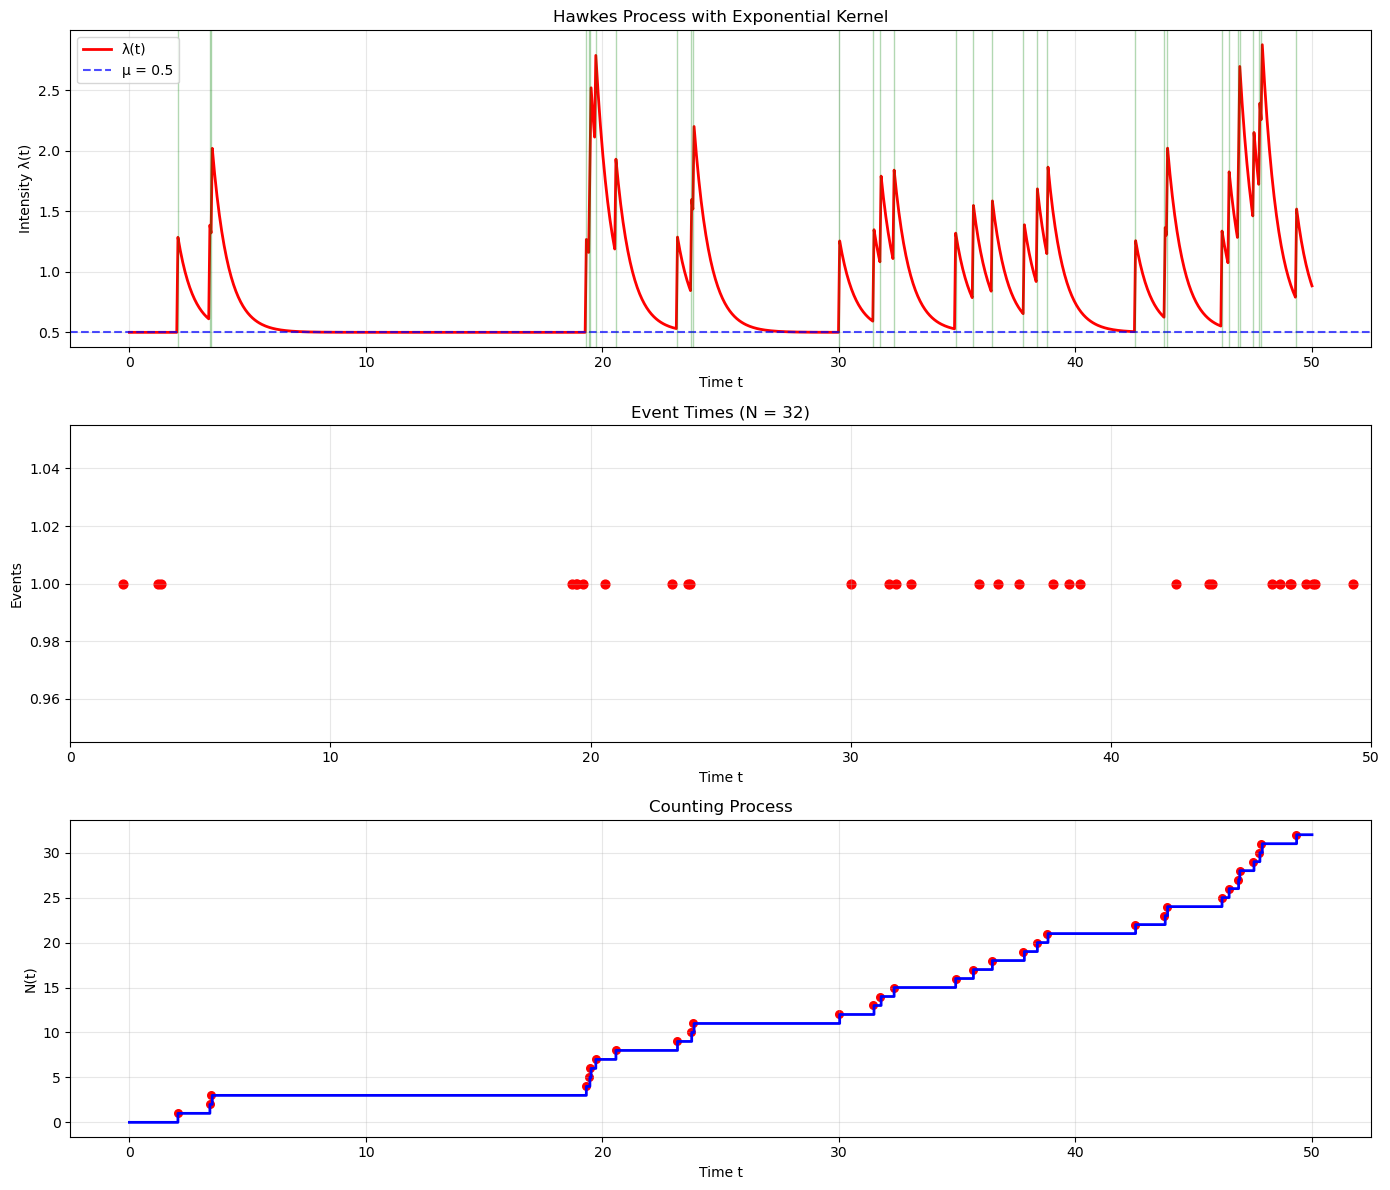

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# =====================================================
# 1. KERNELS
# =====================================================

def exponential_kernel(s, alpha, beta):
    
    return alpha * np.exp(-beta * s)

def power_law_kernel(s, alpha, beta, c=0.1):

    return alpha / (s + c) ** beta

# =====================================================
# 2. INTENSITY FUNCTION
# =====================================================

def hawkes_intensity(t, event_times, mu, kernel_func, **kernel_params):

    excitation = 0.0
    for ti in event_times:
        if ti < t:
            excitation += kernel_func(t - ti, **kernel_params)
    return mu + excitation

# =====================================================
# 3. SIMULATION (Ogata thinning)
# =====================================================

def simulate_hawkes_ogata(mu, kernel_func, T, seed=None, **kernel_params):
    """
    Simulate a univariate Hawkes process with a general kernel using Ogata’s thinning algorithm.
    """
    if seed is not None:
        np.random.seed(seed)
    
    t = 0.0
    event_times = []

    # initial upper bound (a bit large to be safe)
    lambda_bar = mu + 10.0

    while t < T:
        # Step 1: generate candidate time
        u = np.random.uniform()
        w = -np.log(u) / lambda_bar
        t_candidate = t + w
        if t_candidate > T:
            break

        # Step 2: compute true intensity at candidate time
        lambda_t_candidate = hawkes_intensity(t_candidate, event_times, mu,
                                              kernel_func, **kernel_params)

        # Step 3: accept/reject step
        d = np.random.uniform()
        if d <= lambda_t_candidate / lambda_bar:
            event_times.append(t_candidate)

        # Step 4: update
        t = t_candidate
        lambda_bar = max(lambda_t_candidate, mu + 10.0)

    # compute intensity history for plotting
    times = np.linspace(0, T, 1000)
    intensity_history = np.array([
        hawkes_intensity(ti, event_times, mu, kernel_func, **kernel_params)
        for ti in times
    ])

    return np.array(event_times), times, intensity_history

# =====================================================
# 4. VISUALISATION
# =====================================================

def plot_hawkes_process(event_times, times, intensity_history, mu, kernel_name, T):
    """
    Visualize the simulated Hawkes process.
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))
    
    # (1) Intensity λ(t)
    ax1.plot(times, intensity_history, 'r-', linewidth=2, label='λ(t)')
    ax1.axhline(y=mu, color='blue', linestyle='--', alpha=0.7, label=f'μ = {mu}')
    for event_time in event_times:
        ax1.axvline(x=event_time, color='green', alpha=0.3, linestyle='-', linewidth=1)
    ax1.set_title(f'Hawkes Process with {kernel_name} Kernel')
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('Intensity λ(t)')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # (2) Events
    ax2.scatter(event_times, np.ones_like(event_times), color='red', s=40)
    ax2.set_xlim(0, T)
    ax2.set_xlabel('Time t')
    ax2.set_ylabel('Events')
    ax2.set_title(f'Event Times (N = {len(event_times)})')
    ax2.grid(alpha=0.3)

    # (3) Counting process
    counts = np.array([np.sum(event_times <= ti) for ti in times])
    ax3.step(times, counts, where='post', color='blue', linewidth=2)
    ax3.scatter(event_times, np.arange(1, len(event_times)+1), color='red', s=30)
    ax3.set_xlabel('Time t')
    ax3.set_ylabel('N(t)')
    ax3.set_title('Counting Process')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# =====================================================
# 5. DEMONSTRATION
# =====================================================

def main_hawkes():
    mu = 0.5
    alpha = 0.8
    beta = 1.5
    T = 50
    seed = 42

    print("=== Hawkes Process Simulation ===")
    print(f"Parameters: μ={mu}, α={alpha}, β={beta}, T={T}")
    print("----------------------------------")

    # --- Exponential kernel ---
    events_exp, times_exp, intensity_exp = simulate_hawkes_ogata(
        mu, exponential_kernel, T, alpha=alpha, beta=beta
    )

    print(f"Exponential kernel: {len(events_exp)} events")
    plot_hawkes_process(events_exp, times_exp, intensity_exp, mu, "Exponential", T)


if __name__ == "__main__":
    main_hawkes()


In [37]:
for _ in range(1000_000):
    u = np.random.uniform()
    if abs(np.log(u)) > 10:
        print(np.log(u))

-12.104116284599051
-10.997933058229545
-11.683451506670194
-10.436219104617946
-10.500237471830484
-10.21586733535456
-11.057353850922738
-11.932692722668843
-10.54815090991563
-12.251361023853748
-10.137057842209915
-10.271821462731948
-12.094147620697639
-12.98339191341882
-11.134035527730328
-10.230286547659551
-11.676276098204452
-13.014722395745807
-11.651176819488029
-10.709845822862484
-10.90051891225138
-10.127871247070471
-10.376791654918211
-10.746980427356508
-10.446745555875113
-14.47166148508501
-10.91745470135197
-11.862802759009945
-10.495394507566624
-12.157774287073723
-10.692246159478678
-10.011319048596947
-10.007435473996987
-10.397478011381038
-11.225738031453213
-11.099247512367704
-12.189662211883498
-13.998459637394141
-10.802118894084098
-10.56928876715712
-12.882467714176205
-10.6330418742666
-11.377797184365942
-10.559318690681813
-11.802489742527142
